## Transposed conv

### transposed convの実装

In [61]:
# ライブラリ
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm


import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import utils
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
def conv_transposed2d(input, weight, stride=1, padding=1):
    batch_size, ch_in, h_in, w_in = input.shape
    _, ch_out, f_h, f_w = weight.shape

    # 出力サイズ
    h_out = stride * (h_in - 1) + f_h - 2 * padding
    w_out = stride * (w_in -1 ) + f_w - 2 * padding

    output = torch.zeros([batch_size, ch_out, h_out, w_out])

    for b in range(batch_size):
        for i in range(ch_in):
            for o in range(ch_out):
                for h in range(h_in):
                    for w in range(w_in):
                        h_start = h * stride - padding
                        w_start = w * stride - padding
                        for f_h_idx in range(f_h):
                            for f_w_idx in range(f_w):
                                # 出力位置の計算
                                h_out_idx = h_start + f_h_idx
                                w_out_idx = w_start + f_w_idx
    
                                if 0 <= h_out_idx < h_out and 0 <= w_out_idx < w_out:
                                    output[b, o, h_out_idx, w_out_idx] += input[b, i, h, w] * weight[i, o, f_h_idx, f_w_idx]
    return output
    

In [48]:
input = torch.randn(1, 3, 16, 16)
weight = torch.randn(3, 16, 3, 3)

output = conv_transposed2d(input, weight, stride=2, padding=2)
output.shape

torch.Size([1, 16, 29, 29])

In [41]:
input = torch.tensor([[1., 2.], [3., 4.]])
weight = torch.tensor([[-1., 1.], [-2., 2.]])

input = input.unsqueeze(0).unsqueeze(0)
weight = weight.unsqueeze(0).unsqueeze(0)

output = conv_transposed2d(input, weight, stride=2, padding=2)
output.shape

torch.Size([1, 1, 0, 0])

torch.Size([1, 1, 2, 2])

In [49]:
convt_layer = nn.ConvTranspose2d(3, 16, kernel_size=3, stride=2, padding=2, bias=False)
output_ = convt_layer(input)

In [50]:
# 結果を確かめる
input = torch.randn(1, 3, 5, 5)
convt_layer = nn.ConvTranspose2d(3, 4, kernel_size=3, stride=2, padding=2, bias=False)
weight = convt_layer.weight
output_scratch = conv_transposed2d(input, weight, stride=2, padding=2)
output = convt_layer(input)
torch.allclose(output, output_scratch)

True

In [51]:
output_scratch = conv_transposed2d(input, weight, stride=2, padding=2)


In [59]:
tensor = torch.tensor([[[[1, 2],
                         [3, 4 ]]]]).float() 
                      
conv_trans = nn.ConvTranspose2d(1, 1, kernel_size=2,
                                stride=2, padding=1, bias=False) 
print(conv_trans)


with torch.no_grad():
    conv_trans.weight = nn.Parameter(torch.tensor([[[[-1, 1],
                                                     [-2, 2]]]]).float()) #Kernelの初期値を修正

conv_trans(tensor) #転置畳み込み


ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)


tensor([[[[ 2., -4.],
          [ 3., -4.]]]], grad_fn=<ConvolutionBackward0>)

## Autoencoder

### MNISTで試す


In [80]:
# MNISTを取得する
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
train_dataset = datasets.MNIST('./mnist_data',train=True, download=True, transform=transform)
val_dataset = datasets.MNIST('./mnist_data',train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)



In [19]:
X, y = next(iter(train_loader))

In [86]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
    
            nn.Conv2d(16, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X



In [96]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # decoder 
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, X):
        # encoder
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))

        # decoder
        X = F.relu(self.t_conv1(X))
        X = F.sigmoid(self.t_conv2(X))
        return X

In [97]:
# MNISTを取得する
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST('./mnist_data',train=True, download=True, transform=transform)
val_dataset = datasets.MNIST('./mnist_data',train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)



In [98]:
model = Autoencoder()
# loss_func = F.mse_loss
opt = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

In [99]:
# 簡易的な学習ループ
for epoch in range(1, num_epoch+1):

    train_loss = 0.0
    
    for train_batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
        X, _ = data
        # 勾配0
        opt.zero_grad()

        # forward
        output = model(X)
        loss = F.mse_loss(output, X)
        train_loss += loss.item()*X.shape[0]

        # backward
        loss.backward()
        opt.step()

    train_loss = train_loss / len(train_loader)
    print(f'epoch : {epoch} :train loss : {train_loss}')
        
    # model.eval()
    # with torch.no_grad():
    #     for val_batch



epoch : 1 :train loss : 6.176121798151337


epoch : 2 :train loss : 2.415715503031765


epoch : 3 :train loss : 2.070273109717664


epoch : 4 :train loss : 1.9854168229774116


epoch : 5 :train loss : 1.9297642943574422


epoch : 6 :train loss : 1.8888470097137158


epoch : 7 :train loss : 1.858665697546656


epoch : 8 :train loss : 1.8353098046296694


epoch : 9 :train loss : 1.8163412676564157


epoch : 10 :train loss : 1.8012105030799979


torch.Size([128, 1, 28, 28])

In [100]:
# Autoencoderの出力結果を見る
val_loader = DataLoader(val_dataset, batch_size=8)
images, label = next(iter(val_loader))

In [101]:
output = model(images)


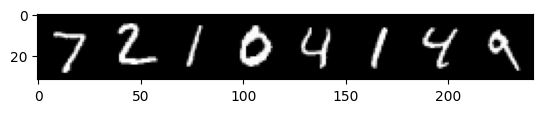

In [102]:
output_grid = torchvision.utils.make_grid(output)
images_grid = torchvision.utils.make_grid(images)


plt.imshow(torch.permute(images_grid, (1, 2, 0)))

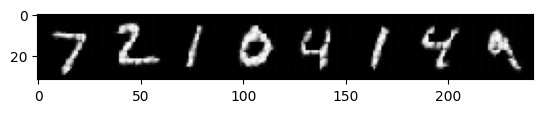

In [103]:
plt.imshow(torch.permute(output_grid, (1, 2, 0)))